---
# SURFER - Experience A 
---
The aim is to see what the effect is on SURFER output variables such as surface temperature if we change the values of the coefficients for carbon fluxes between reservoirs, as well as ocean thermal conductivity. This variation in coefficients is designed to roughly simulate an AMOC shutdown.

We're looking for an initial quantitative analysis of the variations this implies in SURFER as it stands in v2.0 and then in the Victor Couplet's version with three oceanic box.

#### Syntax of the experiences

Experience A stands for the general first experiment class done with SURFER in this master's thesis

- Experience A.0 stands for the Experience A performs with the SURFER v2.0 of Montero (2022)

    - Experience A.0.A stands for the run with different values of $k_{A\to U}$ and $k_{U\to D}$
    
    - Experience A.0.B stands for the run with different values of $\gamma$

    - Experience A.0.C stands for the run with different values of $k_{A\to U}$,$k_{U\to D}$ and $\gamma$. All these three values are reduced compare to their control's values in order to emulate a collapse of the AMOC.
    
    - Experience A.0.D stands for the run with different values of $k_{U\to D}$ and $\gamma$. All these two values are reduced compare to their control's values in order to emulate a collapse of the AMOC.

- Experience A.0.1 stands for the Experience A (performs with the SURFER v2.0 of Montero (2022)) but with a change in the initial condition in order to emulate a collapse of the AMOC. We use the control run until a specific year (for exemple $t_c = 2050$) after which we use the simulation with the coefficients $k_{A\to U}$,$k_{U\to D}$ and $\gamma$ set to values that emulates a collaspe of the AMOC. 

- Experience A.1 stands for the Experience A performs with the SURFER v3.0 of Couplet


#### Syntax of the figures

A.0.A_05.svg stands for complete_experience_name_coefmod.svg so A.0.A_05 stands for an experience with a coefficient modulator of 50%

---

# Experience A.0 - SURFER v2.0
---

In [680]:
using DifferentialEquations
using Plots
using DelimitedFiles
using Interpolations
using Roots
using LaTeXStrings

#### Model parameters and auxiliary expressions

In [681]:
#-----------------------------------------------------
# fixed CarbonCycle+Aerosol parameters
#-----------------------------------------------------
k_AU = (1/4)              # 1/years                                                       | VARIABLE PARAMETER FOR EXPERIENCE A
h_U = 150             # m. Thickness of upper ocean layer
h_D =  h_U*20         # m. Thickness of lower ocean layer
δ = h_D/h_U           # h_L/h_U dimensionless 
δDIC = 1.15           # dimensionless DIC_L/DIC_U at pre industrial
k_UD = (δ * δDIC) / 1000    # 1/years                                                   | VARIABLE PARAMETER FOR EXPERIENCE A
K0 = 0.0314806         # mol/(kg atm) Henry CO2 solubility
K1 = 1.32648E-6        # mol/kg
K2 = 9.19803E-10     # mol/kg
mA = 1.727E20         # moles in atmosphere
mO = 7.8E22           # moles in ocean
GtCtoppm(M_A) = (M_A * 1E6 * 1E15)/(12*mA) # ppm in atmosphere/ PgC in atmosphere
ppmtoGtC(conc) = conc*12*mA/(1E21)
W_U = mO*18E-3*h_U/(h_U+h_D) # whole upper ocean mass kg
W_D = mO*18E-3*h_D/(h_U+h_D) # whole lower ocean mass kg
pH_PI = 8.17
H_PI = 10^(-pH_PI) # mol/kg
CO2conc_a_PI = 280 # ppm
pCO2_a(CO2conc_a) = CO2conc_a*1E-6 # atm
Q = (K1/H_PI + 2*K1*K2/H_PI^2)*K0*pCO2_a(CO2conc_a_PI) # mol/kg
Qm = Q*W_U*12E-3*1E-12 # PgC
k_AL = 1/40            #1/yr
β_L = 1.7             # dimensionless [0.5 - 2.3]
#-----------------------------------------------------
# pre industrial initial conditions for the carbon reservoirs
#-----------------------------------------------------
M_A_PI = ppmtoGtC(CO2conc_a_PI) # PgC
M_U_PI = M_A_PI*(1 + K1/H_PI + K1*K2/H_PI^2)*W_U*K0/mA     # PgC
M_D_PI = M_U_PI*δ*δDIC    # PgC
M_L_PI = 2200 # PgC
#-----------------------------------------------------
# parameters entering temperature c omputation (greenhouse and heat transport parameters)
#-----------------------------------------------------
ECS = 3.5            # Equilibrium CliM_Ae Sensitivity. Celcius / doubling of CO2
TCR = 2.0            # Transient CliM_Ae Response. Celcius / doubling of CO2
F2X = 3.9            # Watts / m^2. Forcing due to a doubling of CO2 concentration
β = F2X/ECS          # Watts / (m^2 Celcius). Inverse equilibrium cliM_Ae sensitivity.
γ = F2X / TCR - β      # Watts / (m^2 Celcius). Thermal conductivity between layers                       | VARIABLE PARAMETER FOR EXPERIENCE A
cvol = 0.13          # (Watts year) / (m^3 Celcius). Volumetric heat capacity of seawater.
TCR = F2X/(β+γ)      # Celsius per doubling of CO2 concentration
#-----------------------------------------------------
# parameters entering temperature computation (aerosol parameters taken from Helwegen2019, changed η)
#-----------------------------------------------------
#η = 0.742         # dimensionless
η = 1.0
αSO2 = 65        # Watts / m^2
βSO2 = 2246      # Mt of S / year
γSO2 = 0.23;     # dimensionless

#----------------------------------------------------
# a couple of auxiliary functions 
#----------------------------------------------------

function B(M_U) #dimensionles
    (sqrt( K1*( Qm*(K1-4K2)*(Qm-2M_U) + K1*M_U^2 ) ) - ( Qm*(K1-4K2) + M_U*(-K1+8K2) ) )/(2M_U*(K1-4K2))
end

function F(M_A,I) # antropogenic forcing
    if I > 0.0
        return F2X*log2(M_A/M_A_PI) - η*αSO2*exp(-(βSO2/I)^γSO2)
    else
        return F2X*log2(M_A/M_A_PI)
    end
end

function H(M_U) # Proton (hydrogen ion) concentration. mol/kg
    H = ( -Qm*K1 + K1*M_U + sqrt( K1*(Qm^2*(K1 - 4*K2) - 2*Qm*(K1 - 4*K2)*M_U + K1*M_U^2) ) )/(2*Qm)
    return H
end

function pH(M_U) # pH global scale
    return -log10(H(M_U))
end

function DIC(M_U) # μmol/kg
    return 1E6(M_U/12E-15)/(W_U)
end

function DIC_D(M_D) # μmol/kg
    return 1E6(M_D/12E-15)/(W_D)
end

function H2CO3(M_U) # μmol/kg
    H2CO3 = DIC(M_U)/(1 + K1/H(M_U) + K1*K2/H(M_U)^2)
    return H2CO3
end

function HCO3(M_U) # μmol/kg
    HCO3 = K1*H2CO3(M_U)/H(M_U)
    return HCO3
end

function CO3(M_U) # μmol/kg
    CO3 = K2*HCO3(M_U)/H(M_U)
    return CO3
end

CO3sat = CO3(M_U_PI)/3.44 

function Ω(M_U)
    return CO3(M_U)/CO3sat
end


#-----------------------------------------------------
# ICE parameters and functions
#-----------------------------------------------------

function Vmcons(model_parameters)
    
    Tp, Tm, Vp, Vm, τmelt, τfreeze = model_parameters
    
    x = ((-Tm + Tp)/(Tm + Tp + 2*sqrt(Tm*Tp)))^(1/3)
    Vm = ( -2 + Vp*(1 + x + 1/x ) )/( -1 + x + 1/x )
    
    return Vm
end

Greenland_params = [1.52, 0.3, 0.77, 0.3526554620064224, 470.0, 5000.0]#[Tp, Tm, Vp, Vm, tau_melt, tau_freeze] 
Greenland_params[4] = Vmcons(Greenland_params)
Antarctica_params = [6.8, 4, 0.44, 0.07857839308355193, 3000.0, 5500.0]#[Tp, Tm, Vp, Vm, tau_melt, tau_freeze] 
Antarctica_params[4] = Vmcons(Antarctica_params)
# sea level rise potential
SLRpotentialG = 7.4
SLRpotentialA = 55



function dV_dt(V, Tf, model_parameters)

    Tp, Tm, Vp, Vm, τmelt, τfreeze = model_parameters
    
    a = 3*(Vm + Vp)/2
    b = -3*Vm*Vp
    c = (Vp - Vm)^3/(2*(Tm - Tp))
    d = ( Tp*Vm^2*(Vm-3Vp) - Tm*Vp^2*(Vp-3Vm) )/(2*(Tm - Tp))
    
    function μ(V,Tf)
        if (- V^3 + a*V^2 + b*V + c*Tf + d) > 0
            return 1/τfreeze
        else
            if V < 1.0e-4
                return 0.0
            else
                return 1/τmelt
            end
        end
    end
       
    return μ(V,Tf)*(- V^3 + a*V^2 + b*V + c*Tf + d)
end

dV_dtA(V,Tf) = dV_dt(V,Tf,Antarctica_params)
dV_dtG(V,Tf) = dV_dt(V,Tf,Greenland_params) 


#-----------------------------------------------------------------------------------
# Sea level rise
#-----------------------------------------------------------------------------------
# SLR ice
SLR_G(VG) = SLRpotentialG*(1-VG)
SLR_A(VA) = SLRpotentialA*(1-VA)
SLRice(VG,VA) =  SLR_G(VG) + SLR_A(VA)
rateSLRice(VG,VA,δT_U) = - SLRpotentialG*(dV_dtG(VG,δT_U))*100 - SLRpotentialA*(dV_dtA(VA,δT_U))*100

# SLR thermal
αU = 2.3e-4 #K^-1
αD = 1.3e-4 #K^-1
SLRthermal(δT_U,δT_D;αU = αU, αD = αD) = αU*δT_U*h_U + αD*δT_D*h_D

# SLR glacier
τ_gl = 200 # years
SLRpotential_gl = 0.5 # meters
ζ = 2 # Related to equlibrium SLRglacier sensitivity to temperature change (Celsius)
SLRgl_eq(δT_U) = SLRpotential_gl*tanh(δT_U/ζ)
SLRglacier(S) = S

# SLRtotal(δT_U,δT_D,VG,VA,S)
SLRtotal(δT_U,δT_D,VG,VA,S) = SLRthermal(δT_U,δT_D) + SLRice(VG,VA) + SLRglacier(S)

SLRtotal (generic function with 1 method)

#### Control model

Model with the basics value of the coefficient

In [682]:
function model!(du,u,p,t)
    M_A, M_U, M_D, M_L, δT_U, δT_D, VG, VA, S = u
    
    Emissions, Injections = p

    Tf = δT_U
    
    du[1] = dM_A = Emissions(t) - k_AU*(M_A - (mA/(W_U*K0))*B(M_U)*M_U) - k_AL*(β_L*M_A_PI*(1 - M_A_PI/M_A) - (M_L - M_L_PI))
    du[2] = dM_U = k_AU*(M_A - (mA/(W_U*K0))*B(M_U)*M_U) - k_UD*(M_U - M_D/(δ*δDIC))
    du[3] = dM_D = k_UD*(M_U - M_D/(δ*δDIC))
    du[4] = dM_L = k_AL*(β_L*M_A_PI*(1 - M_A_PI/M_A) - (M_L - M_L_PI))
    du[5] = dδT_U = ( F(M_A,Injections(t)) - β*δT_U - γ*(δT_U - δT_D) )/(cvol*h_U)
    du[6] = dδT_D = γ*(δT_U - δT_D)/(cvol*h_D)
    du[7] = dVG = dV_dtG(VG,Tf)
    du[8] = dVA = dV_dtA(VA,Tf)
    du[9] = dS = (1/τ_gl)*(SLRgl_eq(Tf) - S)
     
end

model! (generic function with 1 method)

#### Load RCP and SSP emission scenarios

RCP

In [683]:
data_2p6 = readdlm("scenarios/RCP/rcp3");
data_4p5 = readdlm("scenarios/RCP/rcp4p5");
data_6 = readdlm("scenarios/RCP/rcp6");
data_8p5 = readdlm("scenarios/RCP/rcp8p5");
scenario_temp = [data_2p6,data_4p5,data_6,data_8p5];
rcp_names = ["RCP 2.6", "RCP 4.5", "RCP 6", "RCP 8.5"];
scenarios = []
for scenario in scenario_temp
    M_A = zeros(length(scenario[:,1]),2)
    M_A[:,1] = scenario[:,1]
    M_A[:,2] = scenario[:,2] + scenario[:,3]
    push!(scenarios,M_A)
end

#extend scenarios with zero emissions after 2300
extension = zeros(length(2501:15000),2)
extension[:,1] = [year for year in 2501:15000];
ext_scenarios = []
for scenario in scenarios
    push!(ext_scenarios,reduce(vcat, [scenario,extension]))
end
for scenario in ext_scenarios
    scenario[scenario[:,1] .>= 2300,2] = zeros(length(scenario[scenario[:,1] .>= 2300,2]))
end

#itp = LinearInterpolation(data[:,1], data[:,2]) # create interpolation function
rcp_itp = []
for i in 1:length(ext_scenarios)
    itp = LinearInterpolation(ext_scenarios[i][:,1],ext_scenarios[i][:,2])
    push!(rcp_itp,itp)
end

SSP

In [684]:
data_ssp = readdlm("scenarios/SSP/ssp");
ssp_names = data_ssp[2:end,1];
ssp_temp = [data_ssp[i,5:end]*12*1e-3/((12+32)) for i in 2:5]
ssp_time = data_ssp[1,5:end]
# get historic emissions from the RCP scenarios as they were not included in the SSP dataset
yearsbefore = [i for i in 1765:1:1989]
historic_em = rcp_itp[1].(yearsbefore)
yearsafter = [i for i in 2101:2250]
yearsafter2 = [i for i in 2251:12000]
allyears = vcat(yearsbefore,ssp_time,yearsafter,yearsafter2)
ssp_itp = []
for i in 1:4
    em2100 = ssp_temp[i][end]
    # linear decarbonisation that ends in 2250. 
    # Different decarbonisation rates for the different scenarios, as in SSP extrensions paper.
    emafter = [-em2100*(t-2100)/150 + em2100 for t in yearsafter]
    # zero emissions after decarbonisation
    emafter2 = zeros(length(yearsafter2))
    allem= vcat(historic_em,ssp_temp[i],emafter,emafter2)
    em = LinearInterpolation(allyears,allem);
    push!(ssp_itp,em)
end
ssp_names = copy(ssp_names[[2,3,1,4]])
ssp_itp = copy(ssp_itp[[2,3,1,4]]);

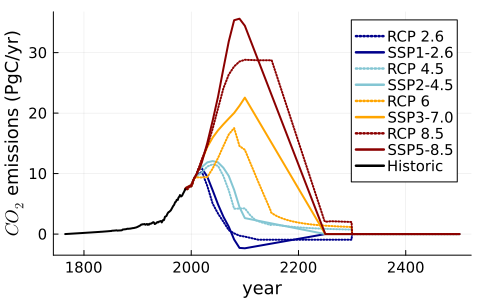

In [685]:
#-----------------------------------------------------------------------
colors = [palette(:blues)[2],palette(:ice)[200],palette(:heat)[2],palette(:heat)[3]]
p = plot(xtickfont=font(10), 
    ytickfont=font(10), 
    guidefont=font(12), 
    legendfont=font(10))
t_start = 1800
t_final = 2500
for i in 1:length(scenarios)
    time = [t for t in 1989:0.1:t_final]
    plot!(time,rcp_itp[i].(time), 
        label = rcp_names[i], lw=2,color=colors[i],ls=:dot)
    plot!(time,ssp_itp[i].(time), 
        label = ssp_names[i], lw=2,color=colors[i])
end
t_historic = [t for t in 1765:0.1:1989]
plot!(t_historic,rcp_itp[1].(t_historic),label="Historic",lc=:black,lw=2,size=(1.61*300,300))
ylabel!(L"CO_2"*" emissions (PgC/yr)")
xlabel!("year")

### Control Run with SSP2-4.5

We run SURFER on every SSP Scenarios from 1800 to 4000 years and then we will only focus on SSP2-4.5 

In [686]:
sol_list_ssp = []
for i in 1:4
    tspan = (1765.0, 4000.0) # time interval
    #ssp
    u_0 = [M_A_PI, M_U_PI, M_D_PI, M_L_PI, 0.0, 0.0, 1.0, 1.0, 0.0] # initial state vector
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(model!, u_0, tspan, sources)
    @time sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-12)
    push!(sol_list_ssp, sol)
end


  0.951491 seconds (2.17 M allocations: 114.277 MiB, 4.34% gc time, 99.76% compilation time)
  0.001443 seconds (78.26 k allocations: 2.280 MiB)
  0.001668 seconds (82.54 k allocations: 2.411 MiB)
  0.001584 seconds (84.50 k allocations: 2.469 MiB)


### Control Run - Plot some relevant quantities 

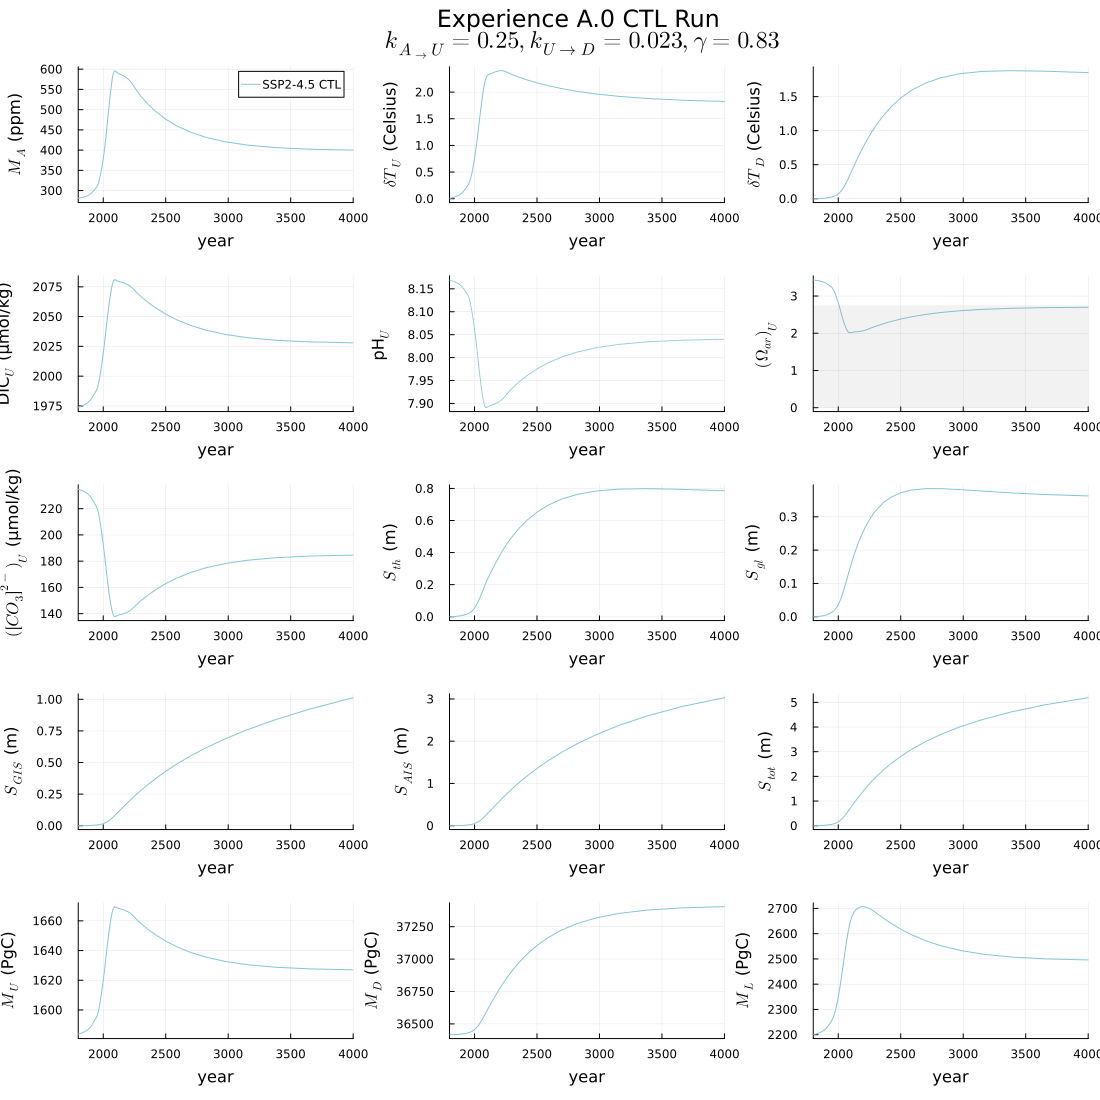

In [687]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0 CTL Run \n"*L"k_{A_\to U}=0.25, k_{U\to D} = 0.023, \gamma = 0.83")

iscen = 2

time = sol_list_ssp[iscen].t
M_A = sol_list_ssp[iscen][1, :]
M_U = sol_list_ssp[iscen][2, :]
M_D = sol_list_ssp[iscen][3, :]
M_L = sol_list_ssp[iscen][4, :]
δT_U = sol_list_ssp[iscen][5, :]
δT_D = sol_list_ssp[iscen][6, :]
VG = sol_list_ssp[iscen][7, :]
VA = sol_list_ssp[iscen][8, :]
S = sol_list_ssp[iscen][9, :]
plot!(time, GtCtoppm.(M_A), color=colors[iscen], ylabel=L"M_A"*" (ppm)", lw=1, label=ssp_names[iscen]*" CTL", subplot=1)
plot!(time, δT_U, color=colors[iscen], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time, δT_D, color=colors[iscen], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time, DIC.(M_U), color=colors[iscen], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time, pH.(M_U), color=colors[iscen], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time, Ω.(M_U), color=colors[iscen], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time, CO3.(M_U), color=colors[iscen], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time, SLRthermal.(δT_U, δT_D), color=colors[iscen], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time, SLRglacier.(S), color=colors[iscen], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time, SLRpotentialG * (1 .- VG), color=colors[iscen], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time, SLRpotentialA * (1 .- VA), color=colors[iscen], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time, SLRtotal.(δT_U, δT_D, VG, VA, S), color=colors[iscen], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time, M_U, color=colors[iscen], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time, M_D, color=colors[iscen], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time, M_L, color=colors[iscen], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)

p



## Experience A.0.A : Variation of $k_{A\to U}$ and $k_{U\to D}$ with SSP2-4.5


Modification of the coefficient values

In [688]:
mod_coef = 1.5
γ = F2X / TCR - β
println(γ)
println(k_AU)
println(k_UD)
k_AU = (1 / 4)*mod_coef
k_UD = ((δ * δDIC) / 1000)*mod_coef 
println(k_AU)
println(k_UD)

0.8357142857142856
0.25
0.023
0.375
0.0345


Run of SSP2-4.5 with de modified coefficient values

In [689]:
sol_list_ssp_A = []
for i in 1:4
    tspan = (1765.0, 4000.0) # time interval
    #ssp
    u_0 = [M_A_PI, M_U_PI, M_D_PI, M_L_PI, 0.0, 0.0, 1.0, 1.0, 0.0] # initial state vector
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(model!, u_0, tspan, sources)
    @time sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-12)
    push!(sol_list_ssp_A, sol)
end


  0.002977 seconds (76.42 k allocations: 2.281 MiB, 4.98% compilation time)
  0.002577 seconds (74.32 k allocations: 2.188 MiB)
  0.002363 seconds (79.25 k allocations: 2.338 MiB)
  0.001701 seconds (79.90 k allocations: 2.358 MiB)


### Experience A.0.A - Plot some relevant quantities 

Plot of the A.0.A_05 Run

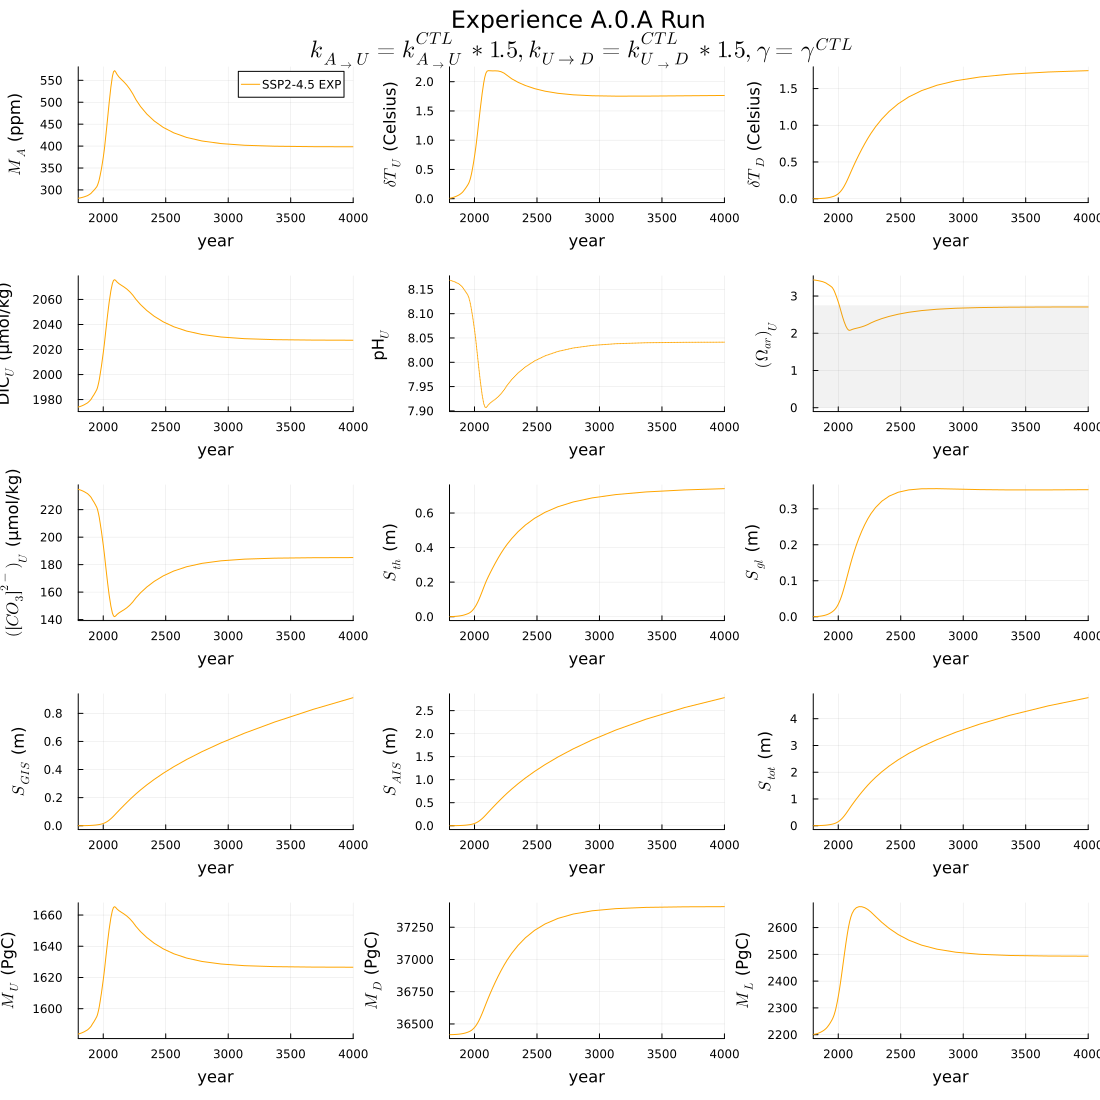

In [690]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.A Run \n" * L"k_{A_\to U}= k_{A_\to U}^{CTL}*1.5, k_{U\to D} = k_{U_\to D}^{CTL}*1.5, \gamma = \gamma^{CTL}")

iscen = 2
color_mod = 3

time_expA = sol_list_ssp_A[iscen].t
M_A_expA = sol_list_ssp_A[iscen][1, :]
M_U_expA = sol_list_ssp_A[iscen][2, :]
M_D_expA = sol_list_ssp_A[iscen][3, :]
M_L_expA = sol_list_ssp_A[iscen][4, :]
δT_U_expA = sol_list_ssp_A[iscen][5, :]
δT_D_expA = sol_list_ssp_A[iscen][6, :]
VG_expA = sol_list_ssp_A[iscen][7, :]
VA_expA = sol_list_ssp_A[iscen][8, :]
S_expA = sol_list_ssp_A[iscen][9, :]
plot!(time_expA, GtCtoppm.(M_A_expA), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen]*" EXP", subplot=1)
plot!(time_expA, δT_U_expA, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_expA, δT_D_expA, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_expA, DIC.(M_U_expA), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_expA, pH.(M_U_expA), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_expA, Ω.(M_U_expA), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_expA, CO3.(M_U_expA), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_expA, SLRthermal.(δT_U_expA, δT_D_expA), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_expA, SLRglacier.(S_expA), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_expA, SLRpotentialG * (1 .- VG_expA), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_expA, SLRpotentialA * (1 .- VA_expA), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_expA, SLRtotal.(δT_U_expA, δT_D_expA, VG_expA, VA_expA, S_expA), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_expA, M_U_expA, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_expA, M_D_expA, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_expA, M_L_expA, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p

Plot of the A.0.A_05 Run and the CTL Run

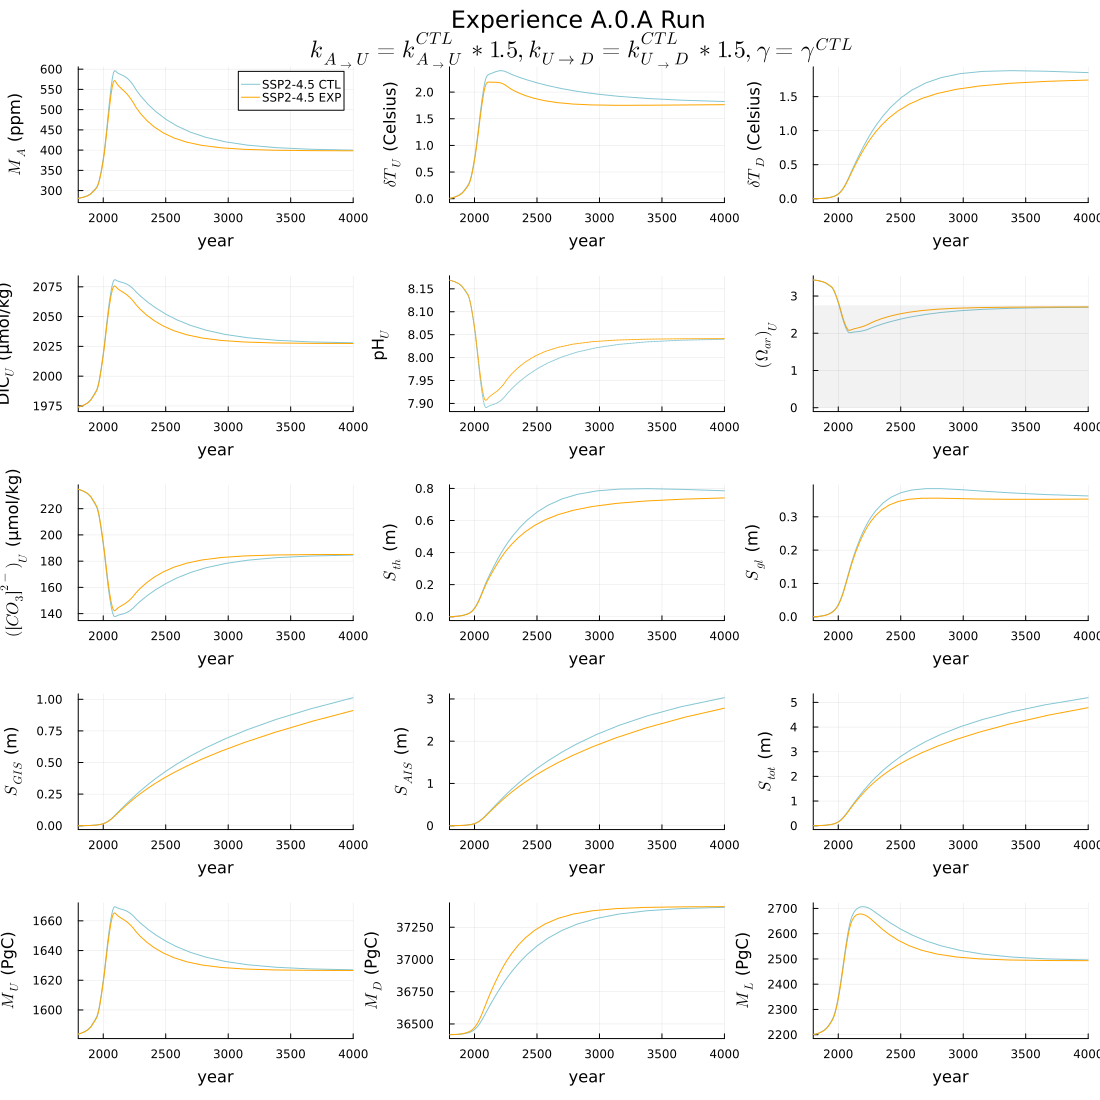

In [691]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.A Run \n" * L"k_{A_\to U}= k_{A_\to U}^{CTL}*1.5, k_{U\to D} = k_{U_\to D}^{CTL}*1.5, \gamma = \gamma^{CTL}")

iscen = 2
color_mod = 3

plot!(time, GtCtoppm.(M_A), color=colors[iscen], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " CTL", subplot=1)
plot!(time, δT_U, color=colors[iscen], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time, δT_D, color=colors[iscen], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time, DIC.(M_U), color=colors[iscen], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time, pH.(M_U), color=colors[iscen], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time, Ω.(M_U), color=colors[iscen], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time, CO3.(M_U), color=colors[iscen], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time, SLRthermal.(δT_U, δT_D), color=colors[iscen], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time, SLRglacier.(S), color=colors[iscen], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time, SLRpotentialG * (1 .- VG), color=colors[iscen], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time, SLRpotentialA * (1 .- VA), color=colors[iscen], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time, SLRtotal.(δT_U, δT_D, VG, VA, S), color=colors[iscen], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time, M_U, color=colors[iscen], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time, M_D, color=colors[iscen], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time, M_L, color=colors[iscen], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

plot!(time_expA, GtCtoppm.(M_A_expA), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " EXP", subplot=1)
plot!(time_expA, δT_U_expA, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_expA, δT_D_expA, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_expA, DIC.(M_U_expA), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_expA, pH.(M_U_expA), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_expA, Ω.(M_U_expA), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_expA, CO3.(M_U_expA), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_expA, SLRthermal.(δT_U_expA, δT_D_expA), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_expA, SLRglacier.(S_expA), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_expA, SLRpotentialG * (1 .- VG_expA), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_expA, SLRpotentialA * (1 .- VA_expA), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_expA, SLRtotal.(δT_U_expA, δT_D_expA, VG_expA, VA_expA, S_expA), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_expA, M_U_expA, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_expA, M_D_expA, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_expA, M_L_expA, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)



hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p

## Experience A.0.B : Variation of $\gamma$ with SSP2-4.5


Modification of the coefficient value

In [692]:
k_AU = (1 / 4) 
k_UD = ((δ * δDIC) / 1000) 
mod_coef = 1.5
γ = (F2X/TCR - β )*mod_coef
println(γ)

1.2535714285714286


Run of SSP2-4.5 with de modified coefficient values

In [693]:
sol_list_ssp_B = []
for i in 1:4
    tspan = (1765.0, 4000.0) # time interval
    #ssp
    u_0 = [M_A_PI, M_U_PI, M_D_PI, M_L_PI, 0.0, 0.0, 1.0, 1.0, 0.0] # initial state vector
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(model!, u_0, tspan, sources)
    @time sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-12)
    push!(sol_list_ssp_B, sol)
end


  0.003116 seconds (78.06 k allocations: 2.317 MiB, 5.15% compilation time)
  0.002882 seconds (75.62 k allocations: 2.219 MiB)
  0.002683 seconds (80.22 k allocations: 2.355 MiB)
  0.002782 seconds (81.53 k allocations: 2.394 MiB)


### Experience A.0.B - Plot some relevant quantities 

Plot of the A.0.B_05 Run


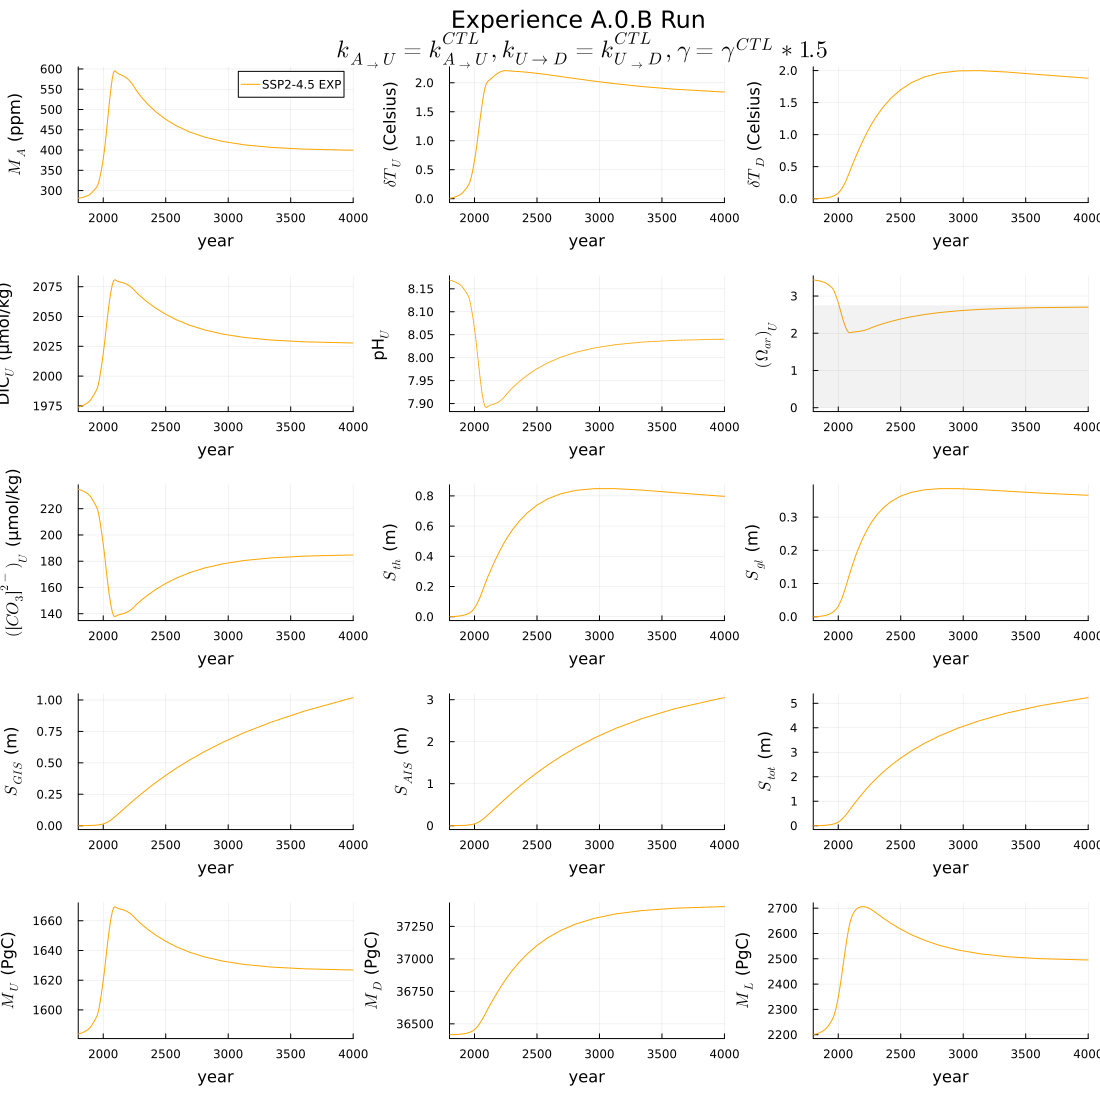

In [694]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.B Run \n" * L"k_{A_\to U}= k_{A_\to U}^{CTL}, k_{U\to D} = k_{U_\to D}^{CTL}, \gamma = \gamma^{CTL}*1.5")

iscen = 2
color_mod = 3

time_expB = sol_list_ssp_B[iscen].t
M_A_expB = sol_list_ssp_B[iscen][1, :]
M_U_expB = sol_list_ssp_B[iscen][2, :]
M_D_expB = sol_list_ssp_B[iscen][3, :]
M_L_expB = sol_list_ssp_B[iscen][4, :]
δT_U_expB = sol_list_ssp_B[iscen][5, :]
δT_D_expB = sol_list_ssp_B[iscen][6, :]
VG_expB = sol_list_ssp_B[iscen][7, :]
VA_expB = sol_list_ssp_B[iscen][8, :]
S_expB = sol_list_ssp_B[iscen][9, :]

plot!(time_expB, GtCtoppm.(M_A_expB), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " EXP", subplot=1)
plot!(time_expB, δT_U_expB, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_expB, δT_D_expB, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_expB, DIC.(M_U_expB), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_expB, pH.(M_U_expB), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_expB, Ω.(M_U_expB), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_expB, CO3.(M_U_expB), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_expB, SLRthermal.(δT_U_expB, δT_D_expB), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_expB, SLRglacier.(S_expB), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_expB, SLRpotentialG * (1 .- VG_expB), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_expB, SLRpotentialA * (1 .- VA_expB), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_expB, SLRtotal.(δT_U_expB, δT_D_expB, VG_expB, VA_expB, S_expB), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_expB, M_U_expB, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_expB, M_D_expB, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_expB, M_L_expB, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p

Plot of the A.0.B_05 Run and the CTL Run

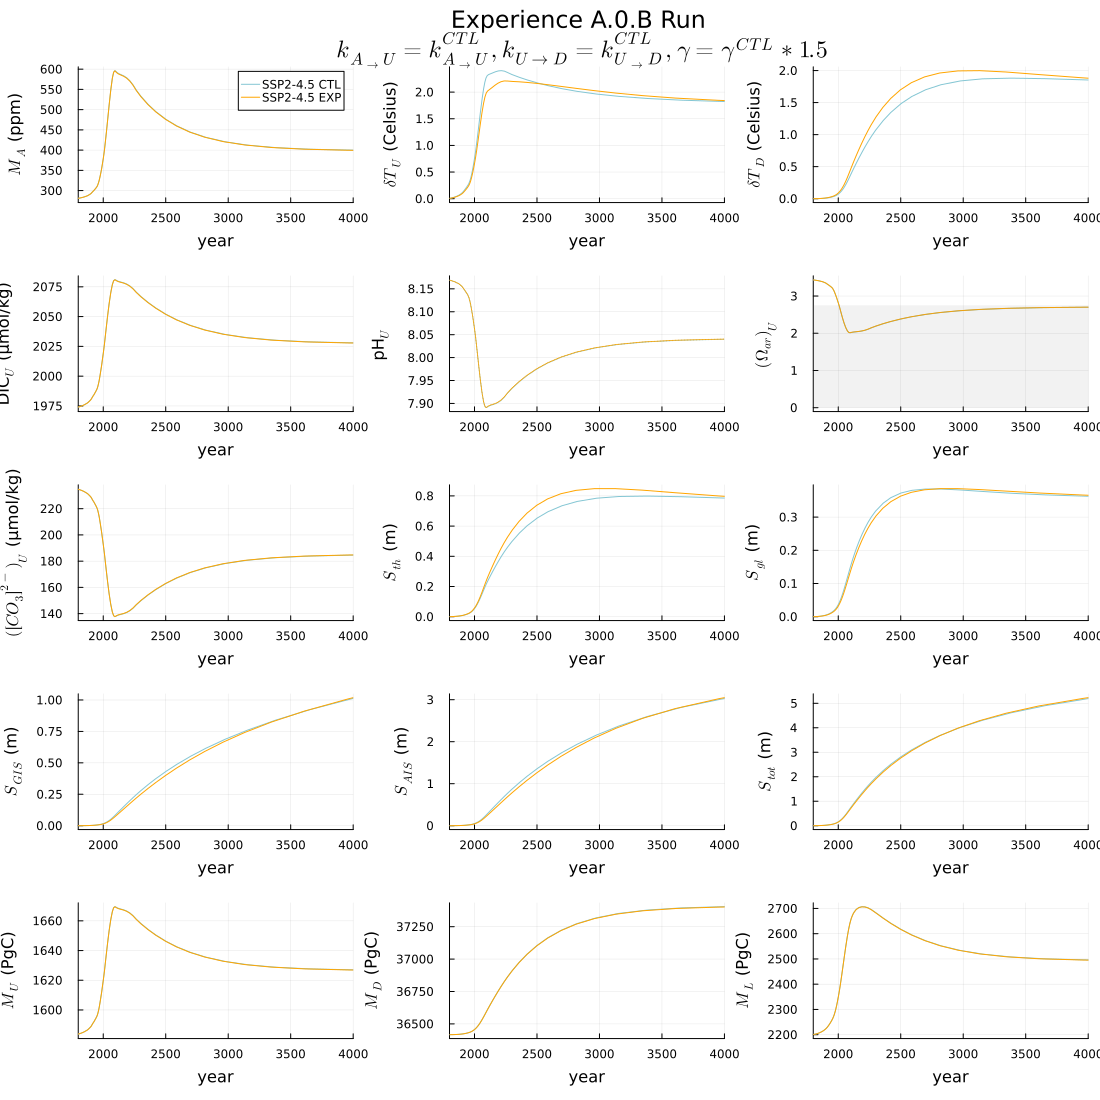

In [695]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.B Run \n" * L"k_{A_\to U}= k_{A_\to U}^{CTL}, k_{U\to D} = k_{U_\to D}^{CTL}, \gamma = \gamma^{CTL}*1.5")

iscen = 2
color_mod = 3

plot!(time, GtCtoppm.(M_A), color=colors[iscen], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " CTL", subplot=1)
plot!(time, δT_U, color=colors[iscen], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time, δT_D, color=colors[iscen], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time, DIC.(M_U), color=colors[iscen], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time, pH.(M_U), color=colors[iscen], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time, Ω.(M_U), color=colors[iscen], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time, CO3.(M_U), color=colors[iscen], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time, SLRthermal.(δT_U, δT_D), color=colors[iscen], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time, SLRglacier.(S), color=colors[iscen], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time, SLRpotentialG * (1 .- VG), color=colors[iscen], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time, SLRpotentialA * (1 .- VA), color=colors[iscen], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time, SLRtotal.(δT_U, δT_D, VG, VA, S), color=colors[iscen], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time, M_U, color=colors[iscen], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time, M_D, color=colors[iscen], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time, M_L, color=colors[iscen], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

plot!(time_expB, GtCtoppm.(M_A_expB), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " EXP", subplot=1)
plot!(time_expB, δT_U_expB, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_expB, δT_D_expB, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_expB, DIC.(M_U_expB), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_expB, pH.(M_U_expB), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_expB, Ω.(M_U_expB), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_expB, CO3.(M_U_expB), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_expB, SLRthermal.(δT_U_expB, δT_D_expB), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_expB, SLRglacier.(S_expB), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_expB, SLRpotentialG * (1 .- VG_expB), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_expB, SLRpotentialA * (1 .- VA_expB), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_expB, SLRtotal.(δT_U_expB, δT_D_expB, VG_expB, VA_expB, S_expB), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_expB, M_U_expB, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_expB, M_D_expB, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_expB, M_L_expB, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)



hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p

## Experience A.0.C : Variation of $\gamma$ and $k_{A\to U}, k_{U\to D}$ with SSP2-4.5, emulation of AMOC = OFF


Modification of the coefficient value


In [696]:
mod_coef = 0.3

k_AU = (1 / 4)*mod_coef 
k_UD = ((δ * δDIC) / 1000)*mod_coef 
γ = (F2X/TCR - β )*mod_coef
println(γ)
println(k_UD)
println(k_AU)

0.25071428571428567
0.0069
0.075


Run of SSP2-4.5 with de modified coefficient values

In [697]:
sol_list_ssp_C = []
for i in 1:4
    tspan = (1765.0, 4000.0) # time interval
    #ssp
    u_0 = [M_A_PI, M_U_PI, M_D_PI, M_L_PI, 0.0, 0.0, 1.0, 1.0, 0.0] # initial state vector
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(model!, u_0, tspan, sources)
    @time sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-12)
    push!(sol_list_ssp_C, sol)
end


  0.001848 seconds (75.77 k allocations: 2.245 MiB, 5.12% compilation time)
  0.002087 seconds (74.00 k allocations: 2.158 MiB)
  0.002279 seconds (77.62 k allocations: 2.269 MiB)
  0.002632 seconds (78.91 k allocations: 2.308 MiB)


### Experience A.0.C - Plot some relevant quantities 

Plot of the A.0.C run


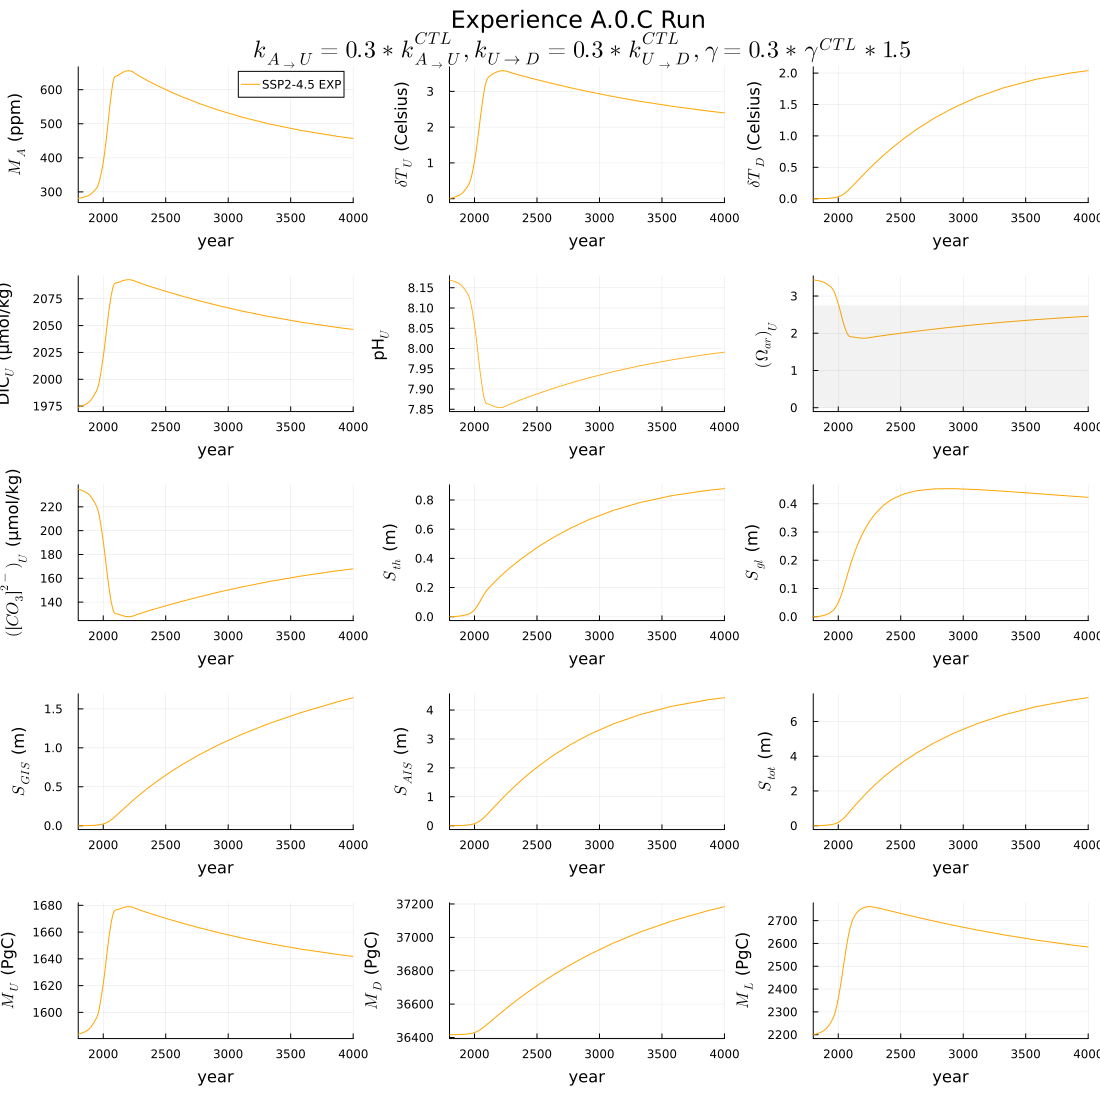

In [698]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.C Run \n" * L"k_{A_\to U}= 0.3*k_{A_\to U}^{CTL}, k_{U\to D} = 0.3*k_{U_\to D}^{CTL}, \gamma = 0.3*\gamma^{CTL}*1.5")

iscen = 2
color_mod = 3

time_expC = sol_list_ssp_C[iscen].t
M_A_expC = sol_list_ssp_C[iscen][1, :]
M_U_expC = sol_list_ssp_C[iscen][2, :]
M_D_expC = sol_list_ssp_C[iscen][3, :]
M_L_expC = sol_list_ssp_C[iscen][4, :]
δT_U_expC = sol_list_ssp_C[iscen][5, :]
δT_D_expC = sol_list_ssp_C[iscen][6, :]
VG_expC = sol_list_ssp_C[iscen][7, :]
VA_expC = sol_list_ssp_C[iscen][8, :]
S_expC = sol_list_ssp_C[iscen][9, :]

plot!(time_expC, GtCtoppm.(M_A_expC), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " EXP", subplot=1)
plot!(time_expC, δT_U_expC, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_expC, δT_D_expC, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_expC, DIC.(M_U_expC), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_expC, pH.(M_U_expC), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_expC, Ω.(M_U_expC), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_expC, CO3.(M_U_expC), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_expC, SLRthermal.(δT_U_expC, δT_D_expC), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_expC, SLRglacier.(S_expC), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_expC, SLRpotentialG * (1 .- VG_expC), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_expC, SLRpotentialA * (1 .- VA_expC), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_expC, SLRtotal.(δT_U_expC, δT_D_expC, VG_expC, VA_expC, S_expC), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_expC, M_U_expC, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_expC, M_D_expC, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_expC, M_L_expC, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p

Plot of the A.0.C run and the CTL run


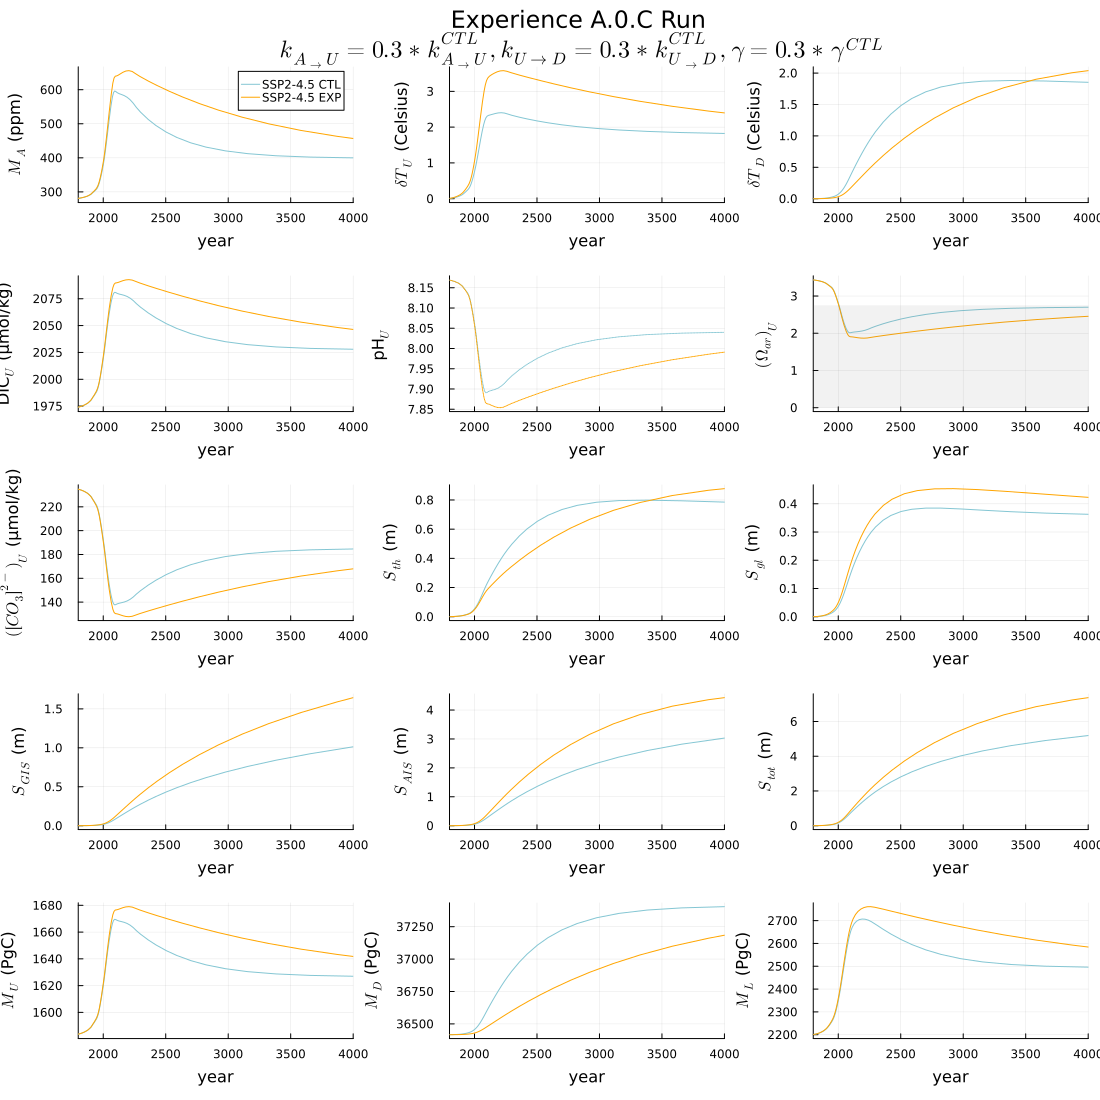

In [699]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.C Run \n" * L"k_{A_\to U}= 0.3*k_{A_\to U}^{CTL}, k_{U\to D} = 0.3*k_{U_\to D}^{CTL}, \gamma = 0.3*\gamma^{CTL}")

iscen = 2
color_mod = 3

plot!(time, GtCtoppm.(M_A), color=colors[iscen], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " CTL", subplot=1)
plot!(time, δT_U, color=colors[iscen], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time, δT_D, color=colors[iscen], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time, DIC.(M_U), color=colors[iscen], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time, pH.(M_U), color=colors[iscen], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time, Ω.(M_U), color=colors[iscen], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time, CO3.(M_U), color=colors[iscen], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time, SLRthermal.(δT_U, δT_D), color=colors[iscen], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time, SLRglacier.(S), color=colors[iscen], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time, SLRpotentialG * (1 .- VG), color=colors[iscen], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time, SLRpotentialA * (1 .- VA), color=colors[iscen], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time, SLRtotal.(δT_U, δT_D, VG, VA, S), color=colors[iscen], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time, M_U, color=colors[iscen], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time, M_D, color=colors[iscen], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time, M_L, color=colors[iscen], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

plot!(time_expC, GtCtoppm.(M_A_expC), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " EXP", subplot=1)
plot!(time_expC, δT_U_expC, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_expC, δT_D_expC, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_expC, DIC.(M_U_expC), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_expC, pH.(M_U_expC), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_expC, Ω.(M_U_expC), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_expC, CO3.(M_U_expC), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_expC, SLRthermal.(δT_U_expC, δT_D_expC), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_expC, SLRglacier.(S_expC), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_expC, SLRpotentialG * (1 .- VG_expC), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_expC, SLRpotentialA * (1 .- VA_expC), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_expC, SLRtotal.(δT_U_expC, δT_D_expC, VG_expC, VA_expC, S_expC), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_expC, M_U_expC, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_expC, M_D_expC, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_expC, M_L_expC, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p

## Experience A.0.D : Variation of $\gamma$ and k_{U\to D}$ with SSP2-4.5, emulation of AMOC = OFF


Modification of the coefficient value


In [700]:
mod_coef = 0.3

k_AU = (1/4)
k_UD = ((δ * δDIC) / 1000)*mod_coef
γ = (F2X / TCR - β)*mod_coef
println(γ)
println(k_UD)
println(k_AU)

0.25071428571428567
0.0069
0.25


Run of SSP2-4.5 with de modified coefficient values


In [701]:
sol_list_ssp_D = []
for i in 1:4
    tspan = (1765.0, 4000.0) # time interval
    #ssp
    u_0 = [M_A_PI, M_U_PI, M_D_PI, M_L_PI, 0.0, 0.0, 1.0, 1.0, 0.0] # initial state vector
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(model!, u_0, tspan, sources)
    @time sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-12)
    push!(sol_list_ssp_D, sol)
end


  0.002915 seconds (73.81 k allocations: 2.196 MiB, 4.53% compilation time)
  0.002524 seconds (72.70 k allocations: 2.128 MiB)
  0.002651 seconds (75.65 k allocations: 2.219 MiB)
  0.002707 seconds (78.28 k allocations: 2.297 MiB)


### Experience A.0.D - Plot some relevant quantities 

Plot of the A.0.D run


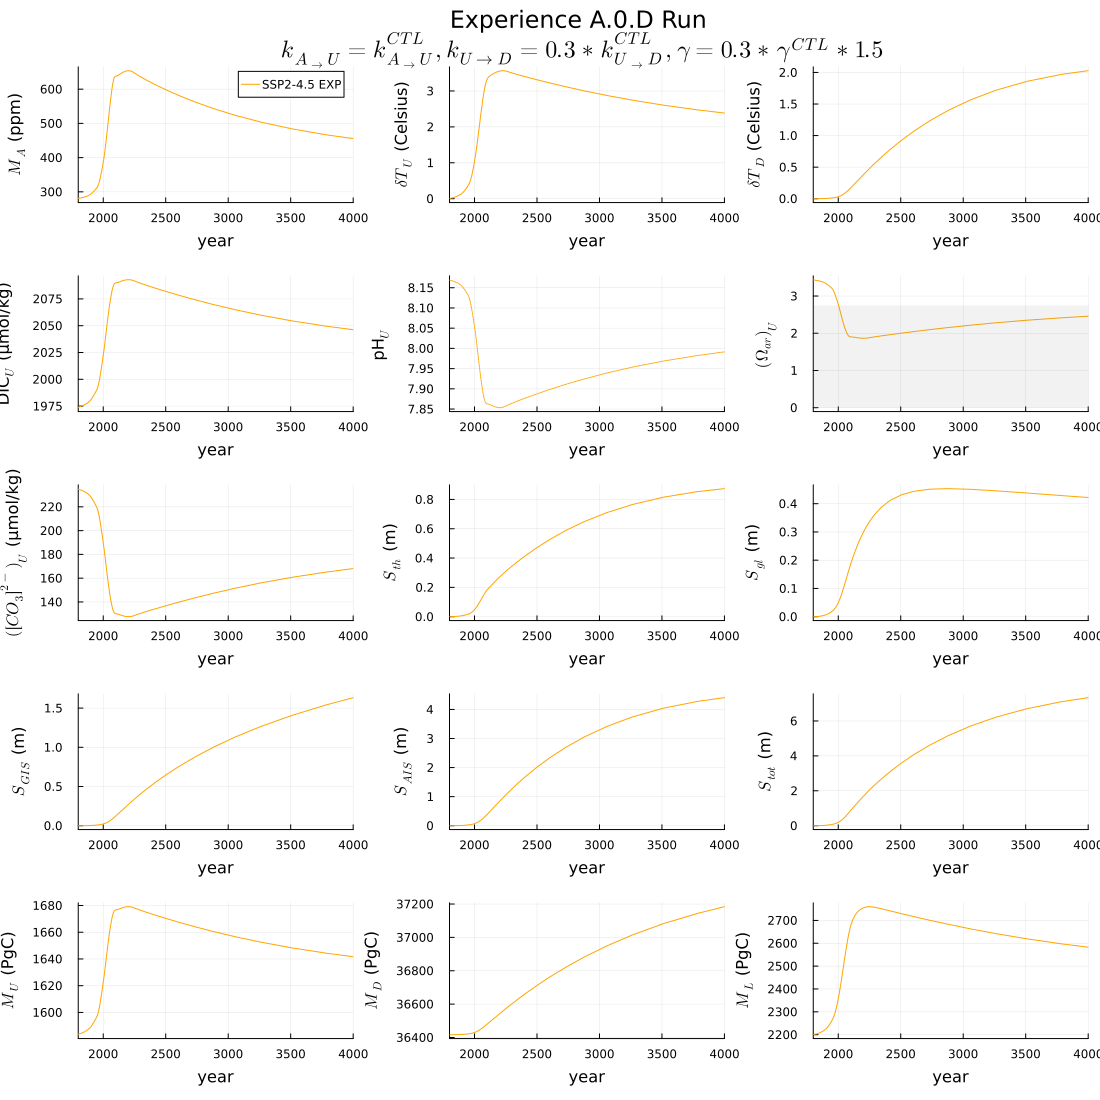

In [702]:
time_list = [t for t in 1765:0.1:4000]
p = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.D Run \n" * L"k_{A_\to U}= k_{A_\to U}^{CTL}, k_{U\to D} = 0.3*k_{U_\to D}^{CTL}, \gamma = 0.3*\gamma^{CTL}*1.5")

iscen = 2
color_mod = 3

time_expD = sol_list_ssp_D[iscen].t
M_A_expD = sol_list_ssp_D[iscen][1, :]
M_U_expD = sol_list_ssp_D[iscen][2, :]
M_D_expD = sol_list_ssp_D[iscen][3, :]
M_L_expD = sol_list_ssp_D[iscen][4, :]
δT_U_expD = sol_list_ssp_D[iscen][5, :]
δT_D_expD = sol_list_ssp_D[iscen][6, :]
VG_expD = sol_list_ssp_D[iscen][7, :]
VA_expD = sol_list_ssp_D[iscen][8, :]
S_expD = sol_list_ssp_D[iscen][9, :]

plot!(time_expD, GtCtoppm.(M_A_expD), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " EXP", subplot=1)
plot!(time_expD, δT_U_expD, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_expD, δT_D_expD, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_expD, DIC.(M_U_expD), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_expD, pH.(M_U_expD), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_expD, Ω.(M_U_expD), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_expD, CO3.(M_U_expD), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_expD, SLRthermal.(δT_U_expD, δT_D_expD), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_expD, SLRglacier.(S_expD), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_expD, SLRpotentialG * (1 .- VG_expD), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_expD, SLRpotentialA * (1 .- VA_expD), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_expD, SLRtotal.(δT_U_expD, δT_D_expD, VG_expD, VA_expD, S_expD), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_expD, M_U_expD, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_expD, M_D_expD, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_expD, M_L_expD, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p

Plot of the A.0.D run and the CTL run


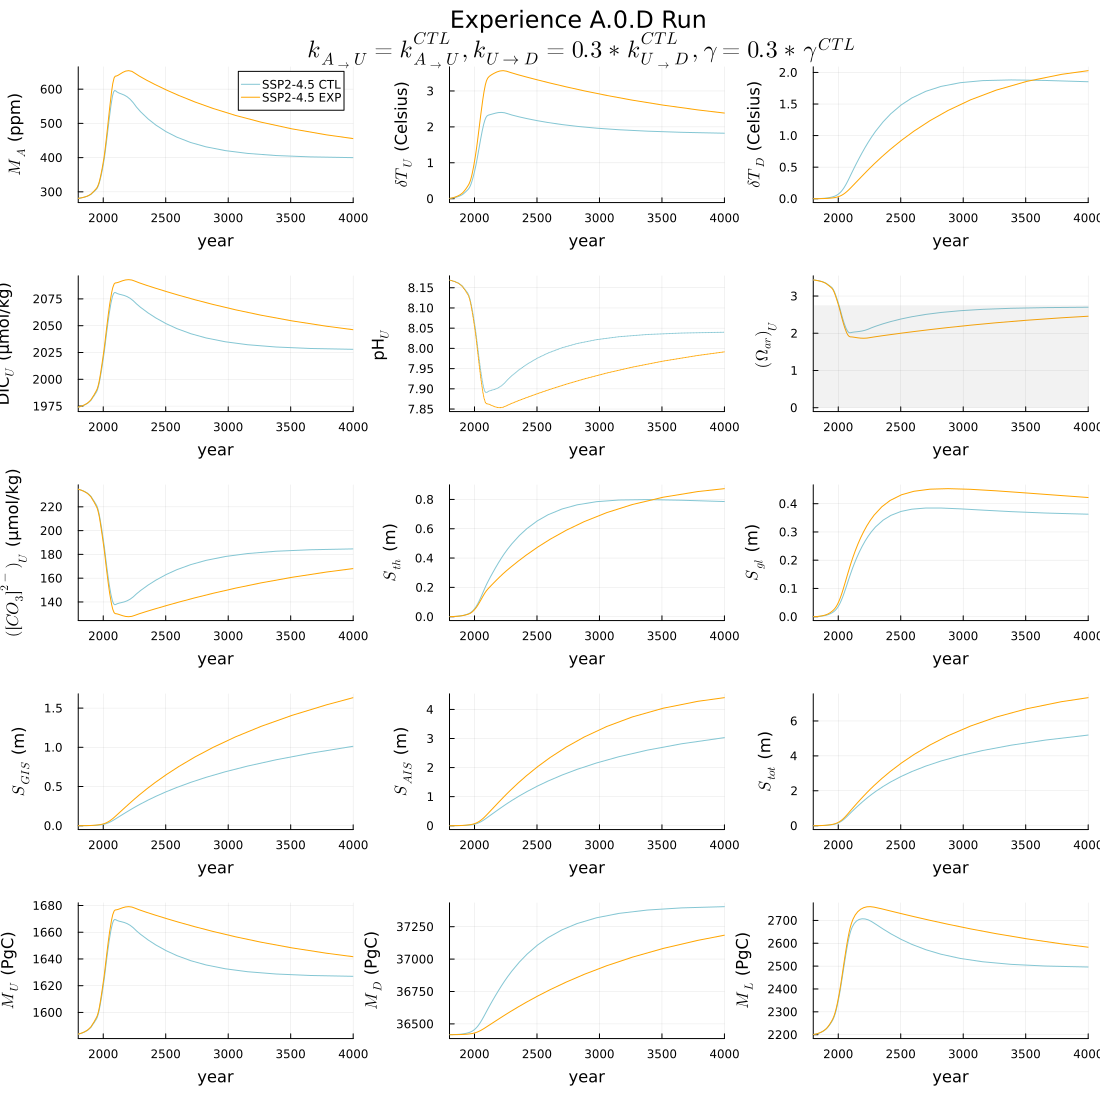

In [703]:
time_list = [t for t in 1765:0.1:4000]
plo = plot(xrange=(1800, 4000), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.D Run \n" * L"k_{A_\to U}= k_{A_\to U}^{CTL}, k_{U\to D} = 0.3*k_{U_\to D}^{CTL}, \gamma = 0.3*\gamma^{CTL}")

iscen = 2
color_mod = 3

plot!(time, GtCtoppm.(M_A), color=colors[iscen], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " CTL", subplot=1)
plot!(time, δT_U, color=colors[iscen], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time, δT_D, color=colors[iscen], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time, DIC.(M_U), color=colors[iscen], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time, pH.(M_U), color=colors[iscen], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time, Ω.(M_U), color=colors[iscen], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time, CO3.(M_U), color=colors[iscen], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time, SLRthermal.(δT_U, δT_D), color=colors[iscen], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time, SLRglacier.(S), color=colors[iscen], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time, SLRpotentialG * (1 .- VG), color=colors[iscen], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time, SLRpotentialA * (1 .- VA), color=colors[iscen], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time, SLRtotal.(δT_U, δT_D, VG, VA, S), color=colors[iscen], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time, M_U, color=colors[iscen], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time, M_D, color=colors[iscen], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time, M_L, color=colors[iscen], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

plot!(time_expD, GtCtoppm.(M_A_expD), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " EXP", subplot=1)
plot!(time_expD, δT_U_expD, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_expD, δT_D_expD, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_expD, DIC.(M_U_expD), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_expD, pH.(M_U_expD), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_expD, Ω.(M_U_expD), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_expD, CO3.(M_U_expD), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_expD, SLRthermal.(δT_U_expD, δT_D_expD), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_expD, SLRglacier.(S_expD), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_expD, SLRpotentialG * (1 .- VG_expD), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_expD, SLRpotentialA * (1 .- VA_expD), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_expD, SLRtotal.(δT_U_expD, δT_D_expD, VG_expD, VA_expD, S_expD), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_expD, M_U_expD, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_expD, M_D_expD, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_expD, M_L_expD, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
plo

## Experience A.0.1 : Emulation of AMOC's collaspe in SURFER v.2.0

### Keep as initial conditions a specific year $t_c = 2050$ of the Control Run

In [704]:
iscen = 2 # Chose a specific ssp scenario
t_c = 2100 # Critical year choosen in order to simulate a tipping of the AMOC
t_0 = 1765.0 # Starting time condition
t_f = 4000.0 # Last year of the simulation
tspan = (t_0, t_f) # time interval

# We need to find the number of iteration needed to go at the t_c time step. 

#println(size(sol_list_ssp[2][1,50]))

nbr_time_it = length(sol_list_ssp[2])
println(nbr_time_it)
nbr_year_sim = tspan[2]-tspan[1]
println(nbr_year_sim)
year_per_it = nbr_year_sim/nbr_time_itt
println(year_per_it)
nbr_it_t_c = trunc(Int,(t_c - t_0)/year_per_it)
println(nbr_it_t_c)


M_A_0 = sol_list_ssp[iscen][1, nbr_it_t_c]
M_U_0 = sol_list_ssp[iscen][2, nbr_it_t_c]
M_D_0 = sol_list_ssp[iscen][3, nbr_it_t_c]
M_L_0 = sol_list_ssp[iscen][4, nbr_it_t_c]
δT_U_0 = sol_list_ssp[iscen][5, nbr_it_t_c]
δT_D_0 = sol_list_ssp[iscen][6, nbr_it_t_c]
VG_0 = sol_list_ssp[iscen][7, nbr_it_t_c]
VA_0 = sol_list_ssp[iscen][8, nbr_it_t_c]
S_0 = sol_list_ssp[iscen][9, nbr_it_t_c]

u_0 = [M_A_PI, M_U_PI, M_D_PI, M_L_PI, 0.0, 0.0, 1.0, 1.0, 0.0] # initial state vector
println(u_0)
u_0_mod = [M_A_0, M_U_0, M_D_0, M_L_0, δT_U_0, δT_D_0, VG_0, VA_0, S_0]
println(u_0_mod)


114
2235.0
20.88785046728972
16
[580.2719999999999, 1583.3315953916112, 36416.626694007056, 2200.0, 0.0, 0.0, 1.0, 1.0, 0.0]
[580.2787010328068, 1583.332182546227, 36416.626699340944, 2200.000143647966, 1.635840321310048e-6, 1.28997747734196e-9, 0.9999999999618291, 0.9999999999842609, 7.518719061659788e-10]


### Experiment with AMOC's OFF emulation since $t_c$

In [705]:
### Control Simulation until t_c ### 

# Coefficient for the control run until t_c 
mod_coef = 1
k_AU = (1 / 4)
k_UD = ((δ * δDIC) / 1000) * mod_coef
γ = (F2X / TCR - β) * mod_coef

# Simulation with an AMOC on the OFF state since t_c and with the control run before
sol_list_ssp_AMOC_OFF_A = []

for i in 1:4
    tspan_1 = (t_0, t_c) # time interval
    #ssp
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob1 = ODEProblem(model!, u_0, tspan_1, sources)
    @time sol1 = solve(prob1, Rosenbrock23(), reltol=1e-3, abstol=1e-12)
    push!(sol_list_ssp_AMOC_OFF_A, sol1)
end

#println(size(sol_list_ssp_AMOC_OFF[1]))
#println(length(sol_list_ssp_AMOC_OFF))
#println(sol_ssp_AMOC_OFF_A)

### AMOC OFF simulation from t_c ###

# Variation of the coefficient to emulate a collapse of the AMOC. 
mod_coef = 0.3
k_AU = (1 / 4)
k_UD = ((δ * δDIC) / 1000) * mod_coef
γ = (F2X / TCR - β) * mod_coef

sol_list_ssp_AMOC_OFF_B = []

for i in 1:4
    tspan_2 = (t_c, t_f) # time interval
    #ssp
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob2 = ODEProblem(model!, u_0_mod, tspan_2, sources)
    @time sol2 = solve(prob2, Rosenbrock23(), reltol=1e-3, abstol=1e-12)
    push!(sol_list_ssp_AMOC_OFF_B, sol2)
end

println(size(sol_list_ssp_AMOC_OFF_B[:][:,:]))
println(sol_list_ssp_AMOC_OFF_B)


  0.002680 seconds (67.20 k allocations: 1.984 MiB, 5.53% compilation time)
  0.001800 seconds (65.11 k allocations: 1.891 MiB)
  0.002294 seconds (65.44 k allocations: 1.905 MiB)
  0.002453 seconds (67.40 k allocations: 1.963 MiB)
  0.001200 seconds (47.94 k allocations: 1.458 MiB, 7.59% compilation time)
  0.000961 seconds (46.48 k allocations: 1.384 MiB)
  0.001091 seconds (51.74 k allocations: 1.540 MiB)
  0.001113 seconds (53.06 k allocations: 1.579 MiB)
(4, 1)
Any[ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{true,Vector{Float64},Tuple{Float64, Float64},…}, Rosenbrock23{9,true,…}, OrdinaryDiffEq.InterpolationData{ODEFunction{true,SciMLBase.AutoSpecialize,…}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Rosenbrock23Cache{Vector{Float64},…}}, DiffEqBase.DEStats, Nothing}([[580.2787010328068, 1583.332182546227, 36416.626699340944, 2200.000143647966, 1.635840321310048e-6, 1


  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0

Excessive output truncated after 524288 bytes.


  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0

#### Plot some relevant quantities

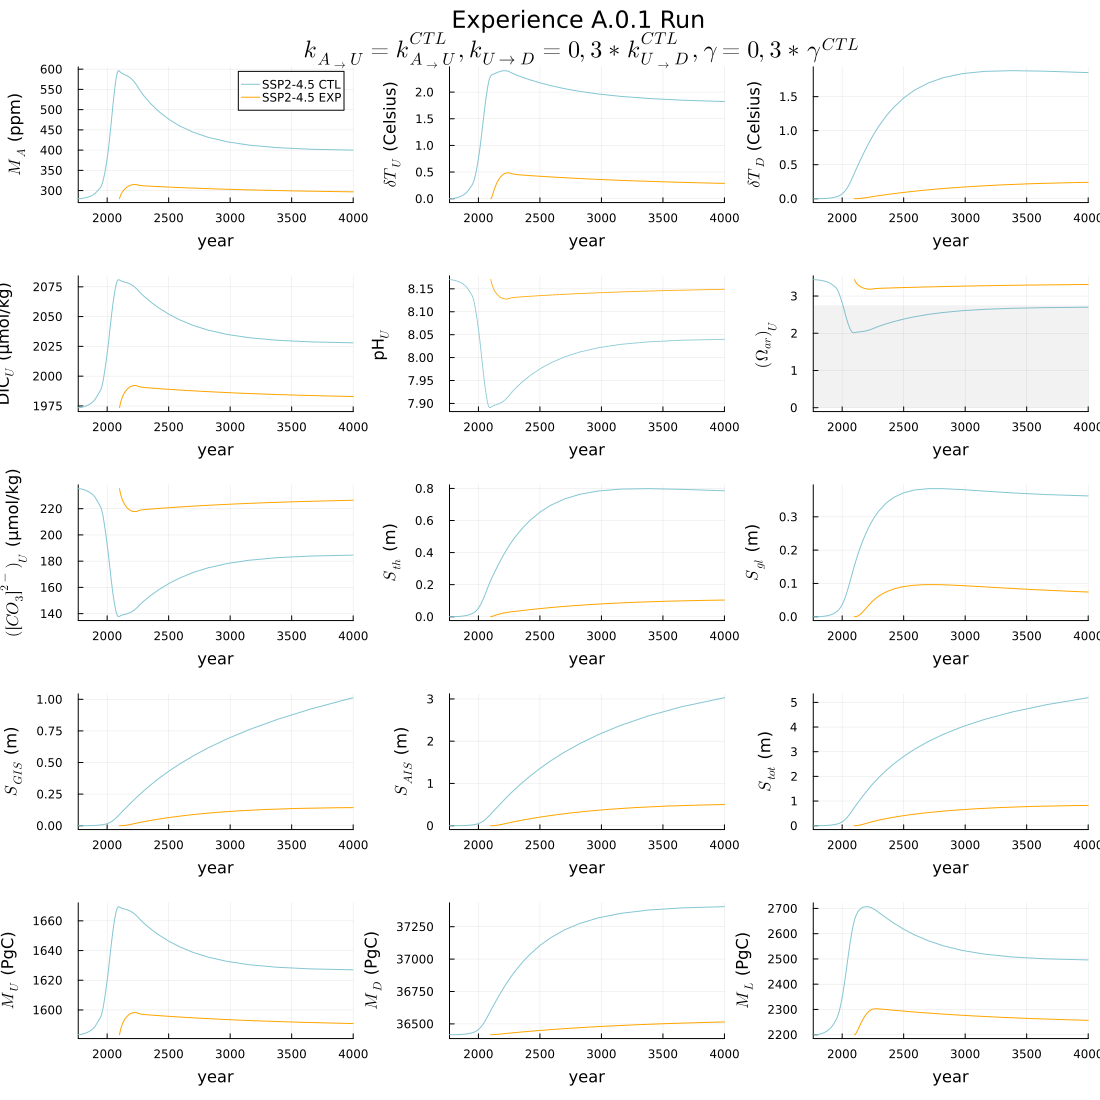

In [706]:
time_list = [t for t in t_0:0.1:t_f]
p = plot(xrange=(t_0, t_f), xlabel="year", layout=(5, 3), size=(1100, 1100), plot_title="Experience A.0.1 Run \n" * L"k_{A_\to U}= k_{A_\to U}^{CTL}, k_{U\to D} = 0,3*k_{U_\to D}^{CTL}, \gamma = 0,3*\gamma^{CTL}")

color_mod = 3

plot!(time, GtCtoppm.(M_A), color=colors[iscen], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " CTL", subplot=1)
plot!(time, δT_U, color=colors[iscen], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time, δT_D, color=colors[iscen], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time, DIC.(M_U), color=colors[iscen], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time, pH.(M_U), color=colors[iscen], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time, Ω.(M_U), color=colors[iscen], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time, CO3.(M_U), color=colors[iscen], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time, SLRthermal.(δT_U, δT_D), color=colors[iscen], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time, SLRglacier.(S), color=colors[iscen], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time, SLRpotentialG * (1 .- VG), color=colors[iscen], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time, SLRpotentialA * (1 .- VA), color=colors[iscen], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time, SLRtotal.(δT_U, δT_D, VG, VA, S), color=colors[iscen], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time, M_U, color=colors[iscen], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time, M_D, color=colors[iscen], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time, M_L, color=colors[iscen], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)


time_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen].t
M_A_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][1, :]
M_U_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][2, :]
M_D_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][3, :]
M_L_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][4, :]
δT_U_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][5, :]
δT_D_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][6, :]
VG_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][7, :]
VA_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][8, :]
S_AMOC_OFF = sol_list_ssp_AMOC_OFF_B[iscen][9, :]

plot!(time_AMOC_OFF, GtCtoppm.(M_A_AMOC_OFF), color=colors[color_mod], ylabel=L"M_A" * " (ppm)", lw=1, label=ssp_names[iscen] * " EXP", subplot=1)
plot!(time_AMOC_OFF, δT_U_AMOC_OFF, color=colors[color_mod], ylabel=L"\delta T_U" * " (Celsius)", lw=1, label=false, subplot=2)
plot!(time_AMOC_OFF, δT_D_AMOC_OFF, color=colors[color_mod], ylabel=L"\delta T_D" * " (Celsius)", lw=1, label=false, subplot=3)
plot!(time_AMOC_OFF, DIC.(M_U_AMOC_OFF), color=colors[color_mod], ylabel="DIC" * L"_U" * " (μmol/kg)", lw=1, label=false, subplot=4)
plot!(time_AMOC_OFF, pH.(M_U_AMOC_OFF), color=colors[color_mod], ylabel="pH" * L"_U", ls=:dot, lw=1, label=false, subplot=5)
plot!(time_AMOC_OFF, Ω.(M_U_AMOC_OFF), color=colors[color_mod], ylabel=L"(\Omega_{ar})_U", lw=1, label=false, subplot=6)
plot!(time_AMOC_OFF, CO3.(M_U_AMOC_OFF), color=colors[color_mod], ylabel=L"([CO_3]^{2-})_U" * " (μmol/kg)", lw=1, label=false, subplot=7)
plot!(time_AMOC_OFF, SLRthermal.(δT_U_AMOC_OFF, δT_D_AMOC_OFF), color=colors[color_mod], ylabel=L"S_{th}" * " (m)", lw=1, label=false, subplot=8)
plot!(time_AMOC_OFF, SLRglacier.(S_AMOC_OFF), color=colors[color_mod], ylabel=L"S_{gl}" * " (m)", lw=1, label=false, subplot=9)
plot!(time_AMOC_OFF, SLRpotentialG * (1 .- VG_AMOC_OFF), color=colors[color_mod], ylabel=L"S_{GIS}" * " (m)", lw=1, label=false, subplot=10)
plot!(time_AMOC_OFF, SLRpotentialA * (1 .- VA_AMOC_OFF), color=colors[color_mod], lw=1, ylabel=L"S_{AIS}" * " (m)", label=false, subplot=11)
plot!(time_AMOC_OFF, SLRtotal.(δT_U_AMOC_OFF, δT_D_AMOC_OFF, VG_AMOC_OFF, VA_AMOC_OFF, S_AMOC_OFF), color=colors[color_mod], ylabel=L"S_{tot}" * " (m)", lw=1, label=false, subplot=12)
plot!(time_AMOC_OFF, M_U_AMOC_OFF, color=colors[color_mod], ylabel=L"M_U" * " (PgC)", lw=1, label=false, subplot=13)
plot!(time_AMOC_OFF, M_D_AMOC_OFF, color=colors[color_mod], ylabel=L"M_D" * " (PgC)", lw=1, label=false, subplot=14)
plot!(time_AMOC_OFF, M_L_AMOC_OFF, color=colors[color_mod], ylabel=L"M_L" * " (PgC)", lw=1, label=false, subplot=15)

hline!([2.75], label=false, legend=:bottomleft, lc=:gray, alpha=0, fill=(0, 0.1, :gray), subplot=6)
p